## Machine Learning Feedback Loop - Predict Ad Click Conversion through XGBoost


1. [Introduction](#Introduction)
2. [Preprocessing](#Preprocessing)
   1. [Read the dataset from S3](#Read-the-dataset-from-S3)
   2. [Prepare data for experiments](#Prepare-data-for-experiments)
   3. [Explore Data](#Explore-Data) 
   4. [Create Features](#Create-Features)
3. [Running Experiments](#Running-Experiments)
   1. [Create train, validation and test datasets](#Create-train,-validation-and-test-datasets)
   2. [Plot Feature Importance](#Plot-Feature-Importance)
   3. [Inferences](#Inferences)

## Introduction

Fraud risk is prevalent in almost every industry, from airlines to retail to financial services. Specifically, the risk is high in online advertising. For companies investing in digital marketing, it is important to contain costs from fraudulent clicks on ads. Online advertising can get cost prohibitive if fraudulent behavior is rampant across online ad channels. In this notebook, we will look at ad click data for mobile apps and predict which clicks will likely yield in app downloads. The outcome from this prediction exercise can enable mobile app developers to efficiently allocate online marketing dollars.

We have created synthetic or artificial dataset simulating 2.4 million clicks across 4 days (Monday through Thursday; July 2nd to 5th of 2018).  

To get started, let's install pre-requisite python packages

In [1]:
#Install relevant python packages
!pip install --upgrade pip
!pip install pyarrow
!pip install joblib
!pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 16.6 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.2
    Uninstalling pip-24.2:
      Successfully uninstalled pip-24.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 77.8 MB/s eta 0:00:00


In [40]:
import boto3
import pandas as pd
import numpy as np
import os
import sagemaker
from sagemaker.amazon.amazon_estimator import get_image_uri
from sagemaker import get_execution_role
# from sagemaker.predictor import csv_serializer
from sagemaker.serializers import CSVSerializer
import matplotlib.pyplot as plt
#import s3fs
import pyarrow.parquet as pq
import gc
import seaborn as sns
import tarfile
import joblib
import xgboost as xgbst
import datetime as dt
from sagemaker.model import Model
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from datetime import *
from sagemaker.inputs import TrainingInput
from sagemaker import image_uris

## Preprocessing

### Read the dataset from S3

The ad click data contains the following elements:

* ip: ip address of click
* app: type of mobile app
* device: type of device the click is coming from (e.g., iphone 6 plus, iphone 7)
* os: type of operating system the click is coming from
* channel: type of channel the click is coming from
* click_time: timestamp of click (UTC)
* is_downloaded: the target that is to be predicted, indicating the app was downloaded

In [5]:
s3_bucket = 'ai620pe08'
s3_prefix = 'Click-Fraud'

s3_train_prefix = os.path.join(s3_prefix, 'train')
s3_val_prefix = os.path.join(s3_prefix, 'val')
s3_output_prefix = os.path.join(s3_prefix, 'output')

s3_train_fn = 'train_sample.csv.zip'

# Location of prepared training and validation datasets on local ec2 instance where SageMaker is running
sm_train_loc = 'click_fraud/train/'
sm_val_loc = 'click_fraud/val/'

In [6]:
!mkdir -p click_fraud/train
!mkdir -p click_fraud/val

In [7]:
#Read the prepared synthetic dataset from local sagemaker instance

file_name = 'ad_track_day'
file_path = 'data'
fn_ext = '.csv'
num_days = 4
dict_of_ad_trk_df = {}


for i in range(1, num_days+1):
    dict_of_ad_trk_df[file_name+str(i)] = pd.read_csv(file_path + '/' + file_name+str(i)+fn_ext)

In [8]:
# dict_of_ad_trk_df['ad_track_day1'].describe()
# a = dict_of_ad_trk_df['ad_track_day1']['channel'].unique()
# print(sorted(a))

#### Run Utility Functions

In [9]:
run clickfraud_processing.py

### Prepare data for experiments

* Experiment 1: Ad clicks from Mon & Tues (train) ==> predict app downloads (part of Thurs)
* Experiment 2: Ad clicks from Mon, Tues & Wed (train) ==> predict app downloads (part of Thurs)
* Experiment 3: Ad clicks from Mon, Tues, Wed & part of Thurs (train) ==> predict app downloads (part of Thurs)

In [10]:
# df_ckFraud_exp1 = pd.concat([dict_of_ad_trk_df[key] for key in ["ad_track_day1", "ad_track_day2"]], ignore_index=True)
df_ckFraud_exp1 = pd.concat([dict_of_ad_trk_df[key] for key in ["ad_track_day1"]], ignore_index=True)
df_ckFraud_exp2 = pd.concat([dict_of_ad_trk_df[key] for key in ["ad_track_day1", "ad_track_day2", "ad_track_day3"]], ignore_index=True)
df_ckFraud_exp3 = pd.concat([dict_of_ad_trk_df[key] for key in ["ad_track_day1", "ad_track_day2", "ad_track_day3", "ad_track_day4"]], ignore_index=True)


# Set the data types for each of the columns
# Ensure we have appropriate column types

cat_var = ['ip','app','device','os','channel', 'is_downloaded']


for var in cat_var:
    df_ckFraud_exp1[var] = df_ckFraud_exp1[var].astype('uint32')
    df_ckFraud_exp2[var] = df_ckFraud_exp2[var].astype('uint32')
    df_ckFraud_exp3[var] = df_ckFraud_exp3[var].astype('uint32')

In [11]:
# Create time features
date_var = ['click_time', 'click_date']
col_name = 'click_time'

for var in date_var:
    df_ckFraud_exp1[var] = pd.to_datetime(df_ckFraud_exp1[var])
    df_ckFraud_exp2[var] = pd.to_datetime(df_ckFraud_exp2[var])
    df_ckFraud_exp3[var] = pd.to_datetime(df_ckFraud_exp3[var])
               
df_ckFraud_exp1 = create_date_ftrs(df_ckFraud_exp1, col_name)
df_ckFraud_exp2 = create_date_ftrs(df_ckFraud_exp2, col_name)
df_ckFraud_exp3 = create_date_ftrs(df_ckFraud_exp3, col_name)

### Explore Data

#### Top 10 apps on Mon - Experiment 1

The popular apps, defined by the number of ad clicks pertaining to the app, are not same between when an app is not downloaded vs when it is downloaded. In other words, although certain mobile app ads are clicked widely, they are not necessarily the ones getting downloaded

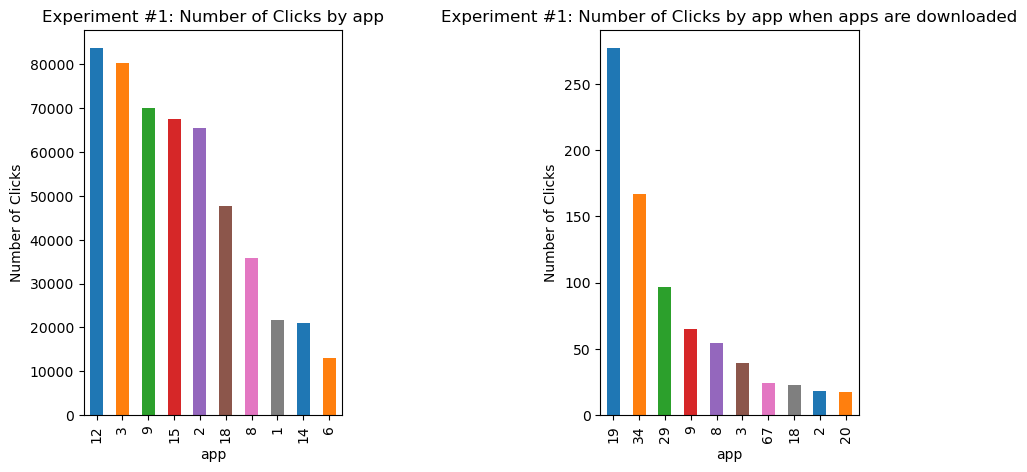

In [12]:
%matplotlib inline

plot_clickcnt_ftr(df_ckFraud_exp1, 'app', '1')

#### Top 10 devices on Mon - Experiment 1

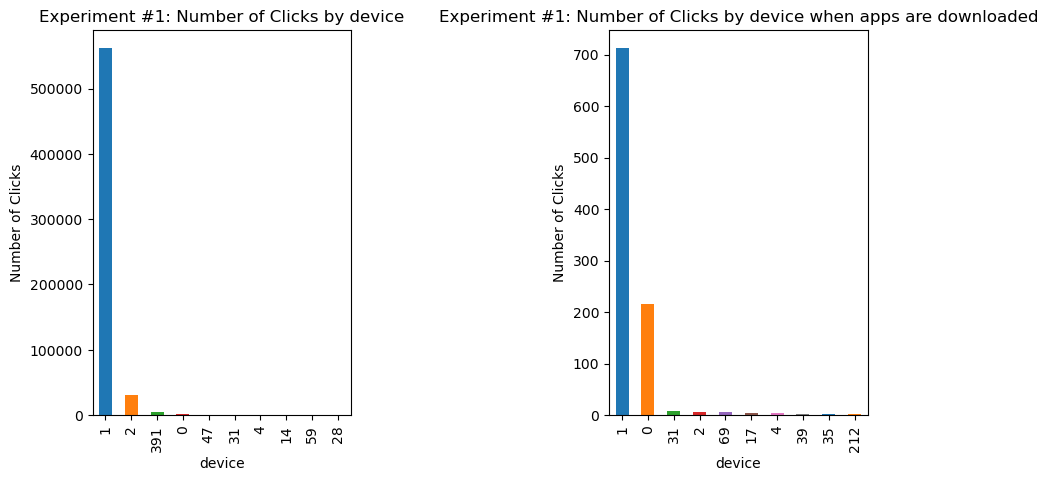

In [13]:
%matplotlib inline

plot_clickcnt_ftr(df_ckFraud_exp1, 'device', '1')

Same scenario as apps. Popular devices are different between when apps are downloaded vs when they are not

#### Top 10 operating systems on Mon - Experiment 1

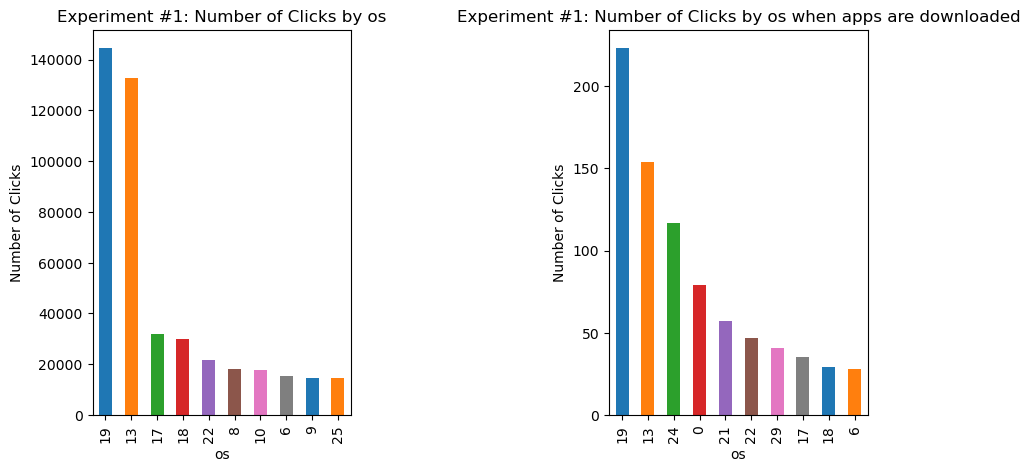

In [14]:
%matplotlib inline

plot_clickcnt_ftr(df_ckFraud_exp1, 'os', '1')

Popular operating systems are more or less same between when apps are downloaded vs when they are not

#### Top 10 channels on Mon - Experiment 1

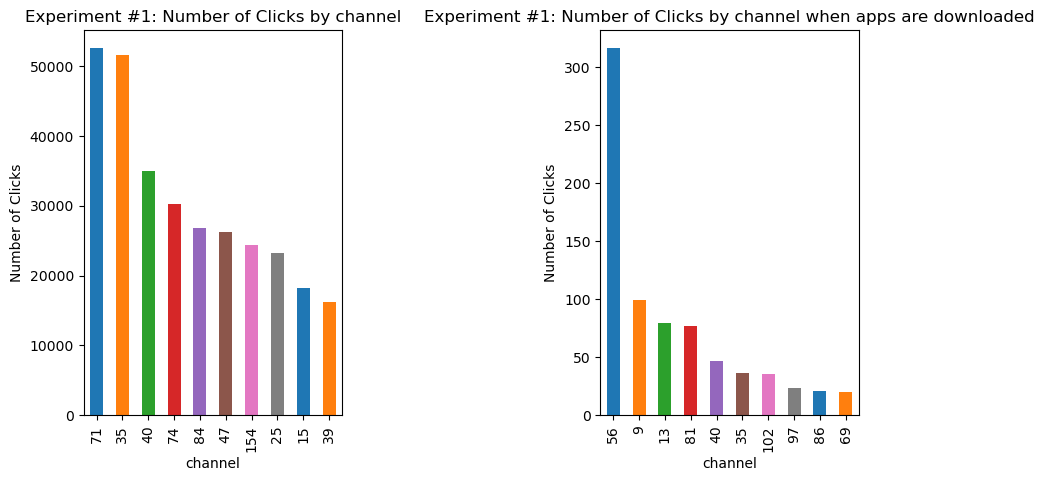

In [15]:
%matplotlib inline

plot_clickcnt_ftr(df_ckFraud_exp1, 'channel', '1')

Same scenario as apps. Popular channels are different between when apps are downloaded vs when they are not

### Create Features

In [16]:
gc.collect()

31727

In [17]:
# Create appropriate features -- from a given ip address and time, number of clicks generated
df_ckFraud_exp1 = count_clicks(df_ckFraud_exp1)
df_ckFraud_exp2 = count_clicks(df_ckFraud_exp2)
df_ckFraud_exp3 = count_clicks(df_ckFraud_exp3)

# Drop click time, date and ip 
df_ckFraud_exp1 = df_ckFraud_exp1.drop(['click_time', 'click_date', 'ip'], axis=1)
df_ckFraud_exp2 = df_ckFraud_exp2.drop(['click_time', 'click_date', 'ip'], axis=1)
df_ckFraud_exp3 = df_ckFraud_exp3.drop(['click_time', 'click_date', 'ip'], axis=1)

In [18]:
# Encode categorical columns -- frequency encoding
df_ckFraud_exp1 = encode_cat_ftrs(df_ckFraud_exp1)
df_ckFraud_exp2 = encode_cat_ftrs(df_ckFraud_exp2)
df_ckFraud_exp3 = encode_cat_ftrs(df_ckFraud_exp3)

In [19]:
# Check the prepared dataset
df_ckFraud_exp1.tail()

,app,device,os,channel,is_downloaded,day,hour,minute,second,clicks_by_ip_day_hr,clicks_by_ip_hr_chnl,clicks_by_ip_hr_os,clicks_by_ip_hr_app,clicks_by_ip_hr_device,app_freq,device_freq,os_freq,channel_freq
599995,61,1,16,147,0,2,16,12,17,112,3,3,2,98,0.012868,0.93571,0.018125,0.021568
599996,9,1,22,35,0,2,16,12,17,24,2,1,4,20,0.116657,0.93571,0.036277,0.085962
599997,28,1,6,36,0,2,16,12,17,35,3,7,1,35,0.004857,0.93571,0.025397,0.016295
599998,61,1,13,147,0,2,16,12,17,38,1,2,1,37,0.012868,0.93571,0.221382,0.021568
599999,15,1,25,71,0,2,16,12,17,23,7,3,5,23,0.112660,0.93571,0.023993,0.087570


In [20]:
#df_ckFraud_exp2.groupby('app').size()
#df_ckFraud_exp2.shape[0]
# df_ckFraud_exp1['day'].unique()
df_ckFraud_exp1.shape

(600000, 18)

#### Ensure there are no missing values

In [21]:
# Ensure there are no missing values
df_ckFraud_exp1.apply(lambda x: sum(x.isnull()))
#df_ckFraud_exp1.apply(lambda x: sum(x.isna()))
#data.apply(lambda x: sum(x.isnull()))

app                       0
device                    0
os                        0
channel                   0
is_downloaded             0
day                       0
hour                      0
minute                    0
second                    0
clicks_by_ip_day_hr       0
clicks_by_ip_hr_chnl      0
clicks_by_ip_hr_os        0
clicks_by_ip_hr_app       0
clicks_by_ip_hr_device    0
app_freq                  0
device_freq               0
os_freq                   0
channel_freq              0
dtype: int64

In [22]:
# Correlation
df_ckFraud_exp2.corr()

,app,device,os,channel,is_downloaded,day,hour,minute,second,clicks_by_ip_day_hr,clicks_by_ip_hr_chnl,clicks_by_ip_hr_os,clicks_by_ip_hr_app,clicks_by_ip_hr_device,app_freq,device_freq,os_freq,channel_freq
app,1.000000,0.151100,0.137169,-0.018555,0.056048,-0.001745,-0.005837,0.004931,-0.000941,0.001318,-0.037514,-0.020609,-0.062875,-0.013790,-0.428591,-0.090975,-0.044542,-0.094525
device,0.151100,1.000000,0.859331,-0.085785,0.007017,0.006722,-0.007077,-0.000403,-0.001031,0.001357,0.004561,-0.025469,-0.009378,-0.027942,-0.042371,-0.435897,-0.109731,0.034134
os,0.137169,0.859331,1.000000,-0.063002,-0.001591,0.007669,-0.008201,-0.001073,-0.001552,0.003492,0.005728,-0.038954,-0.005215,-0.023132,-0.041813,-0.392699,-0.187411,0.011814
channel,-0.018555,-0.085785,-0.063002,1.000000,-0.017334,0.079463,-0.071021,0.013357,-0.001677,-0.013221,-0.080853,-0.019728,-0.013609,-0.000984,0.077422,0.087759,0.022104,-0.318993
is_downloaded,0.056048,0.007017,-0.001591,-0.017334,1.000000,0.000225,-0.000714,0.003877,-0.000829,-0.006001,-0.010094,-0.008493,-0.010055,-0.006998,-0.059781,-0.043890,-0.005233,-0.038705
day,-0.001745,0.006722,0.007669,0.079463,0.000225,1.000000,-0.866023,-0.076775,-0.006746,-0.029464,-0.015959,0.013620,0.014200,0.033923,0.034723,0.027705,0.008437,-0.060367
hour,-0.005837,-0.007077,-0.008201,-0.071021,-0.000714,-0.866023,1.000000,0.086723,0.006825,0.065606,0.030727,0.000015,0.001225,-0.019307,-0.023790,-0.036760,-0.009570,0.068526
minute,0.004931,-0.000403,-0.001073,0.013357,0.003877,-0.076775,0.086723,1.000000,-0.069343,0.006743,0.007289,0.001920,0.004444,-0.002286,0.022301,-0.002642,0.002827,-0.001650
second,-0.000941,-0.001031,-0.001552,-0.001677,-0.000829,-0.006746,0.006825,-0.069343,1.000000,-0.001377,-0.001305,0.000240,-0.001511,-0.001423,-0.003575,-0.001152,-0.001051,-0.003392
clicks_by_ip_day_hr,0.001318,0.001357,0.003492,-0.013221,-0.006001,-0.029464,0.065606,0.006743,-0.001377,1.000000,0.646329,0.688075,0.783809,0.888336,0.012967,-0.071263,-0.001953,0.003572


<Axes: >

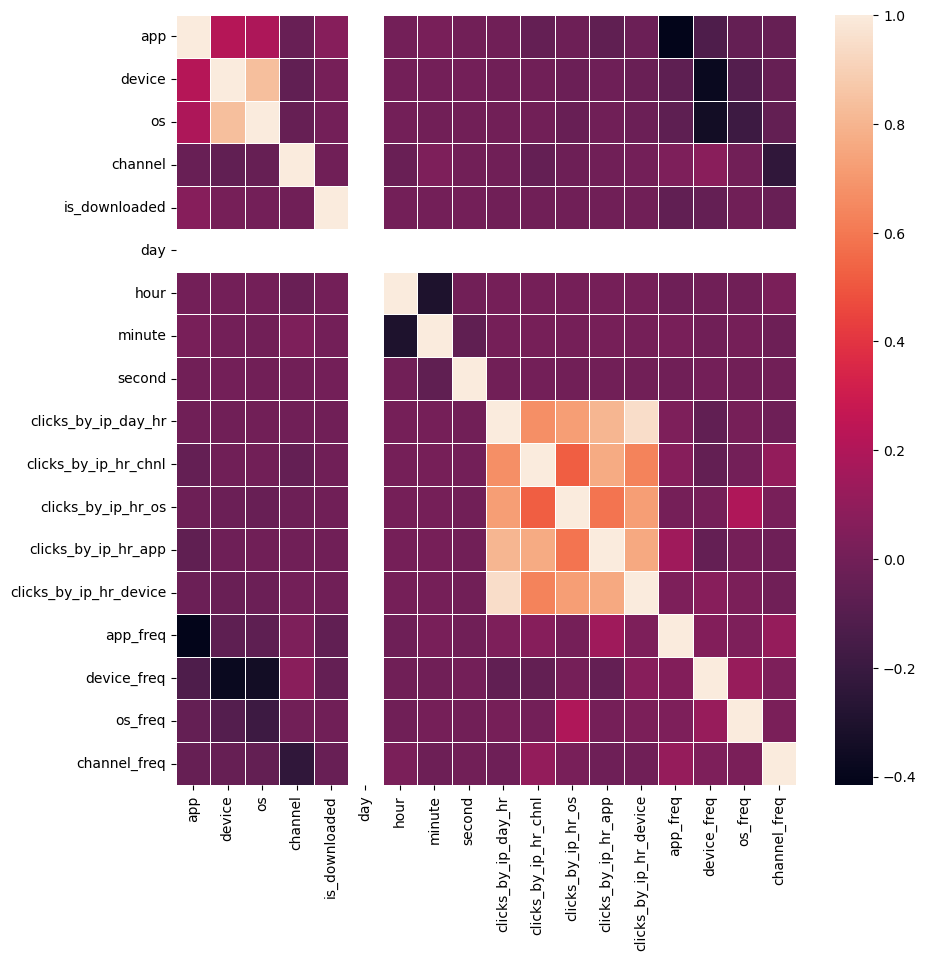

In [23]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(df_ckFraud_exp1.corr(), linewidth=.5, ax=ax)

## Running Experiments

To understand the significance of feedback loop, we will train tree-based model (XGBoost) to predict the probability that an ad click (related to an app) results in app download:
* Experiment 1: Train on click data for Monday and Tuesday and predict/score portion of the clicks from Thursday (clicks from later part of the day)
* Experiment 2: Let’s assume that we have more data available in data lake environment to retrain the classification model. We will train on click data for Monday, Tuesday, & Wednesday and predict/score portion of the clicks from Thursday
* Experiment 3: Similarly, we will train on click data for Monday, Tuesday, Wednesday & part of Thursday and predict/score portion of the clicks from Thursday


Set current experiment: Fit the classification model for each of the experiments, host the trained model and run inferences. For each of the three experiments, run "create train, validation and test" and "training" sections

In [24]:
df_ckFraud_exp1.tail()
#len(df_ckFraud_exp1)
#len(df_ckFraud_exp2)
#len(df_ckFraud_exp3)

,app,device,os,channel,is_downloaded,day,hour,minute,second,clicks_by_ip_day_hr,clicks_by_ip_hr_chnl,clicks_by_ip_hr_os,clicks_by_ip_hr_app,clicks_by_ip_hr_device,app_freq,device_freq,os_freq,channel_freq
599995,61,1,16,147,0,2,16,12,17,112,3,3,2,98,0.012868,0.93571,0.018125,0.021568
599996,9,1,22,35,0,2,16,12,17,24,2,1,4,20,0.116657,0.93571,0.036277,0.085962
599997,28,1,6,36,0,2,16,12,17,35,3,7,1,35,0.004857,0.93571,0.025397,0.016295
599998,61,1,13,147,0,2,16,12,17,38,1,2,1,37,0.012868,0.93571,0.221382,0.021568
599999,15,1,25,71,0,2,16,12,17,23,7,3,5,23,0.112660,0.93571,0.023993,0.087570


In [25]:
# Experiment 3
# current_experiment = df_ckFraud_exp3 
# exp_prefix = 'exp3' 

# Experiment 2
# current_experiment = df_ckFraud_exp2
# exp_prefix = 'exp2' 

# Experiment 1
current_experiment = df_ckFraud_exp1
exp_prefix = 'exp1'


### Create train, validation and test datasets

In [26]:
print(s3_train_prefix + '/' + exp_prefix + '/train_ckFraud.csv')

Click-Fraud/train/exp1/train_ckFraud.csv


Create test dataset - last 5% of clicks from Thursday. The same test dataset is used across all the three experiments

In [27]:
# Create test dataset
# Sort by hour, minute and second --> pick the last 5% (120,000 records)
test_data = df_ckFraud_exp3.sort_values(['day', 'hour', 'minute', 'second'], ascending=False).head(n=120000)
# Rearrange test data so that is_downloaded is the first column
test_data = pd.concat([test_data['is_downloaded'], test_data.drop(['is_downloaded'], axis=1)], axis=1) 


# Create new dataset for experiment 3 (this excludes data from test dataset)
df_ckFraud_fil_exp3 = df_ckFraud_exp3.sort_values(['day', 'hour', 'minute', 'second'], ascending=True).head(n=2280000)

#### Only for experiment # 3
Since df_ckFraud_fil_exp3 has changed

In [28]:
if exp_prefix=='exp3':
    current_experiment = df_ckFraud_fil_exp3

In [29]:
# Create dataset in a format required by XGBoost
current_experiment = pd.concat([current_experiment['is_downloaded'], current_experiment.drop(['is_downloaded'], axis=1)], axis=1) 

In [30]:
current_experiment.head()

,is_downloaded,app,device,os,channel,day,hour,minute,second,clicks_by_ip_day_hr,clicks_by_ip_hr_chnl,clicks_by_ip_hr_os,clicks_by_ip_hr_app,clicks_by_ip_hr_device,app_freq,device_freq,os_freq,channel_freq
0,0,3,1,13,114,2,14,32,21,1,1,1,1,1,0.133870,0.93571,0.221382,0.011248
1,0,3,1,19,114,2,14,33,34,1,1,1,1,1,0.133870,0.93571,0.240763,0.011248
2,0,3,1,13,114,2,14,34,12,1,1,1,1,1,0.133870,0.93571,0.221382,0.011248
3,0,14,1,13,155,2,14,34,52,1,1,1,1,1,0.035148,0.93571,0.221382,0.001152
4,0,3,1,13,114,2,14,35,8,1,1,1,1,1,0.133870,0.93571,0.221382,0.011248


In [31]:
current_experiment['day'].max()

2

In [32]:
current_experiment.shape

(600000, 18)

In [33]:
# Create train (80%), validation (20%) datasets

train_data, validation_data = np.split(current_experiment.sample(frac=1, random_state=4567), [int(0.8 * len(current_experiment))])

# Save training and validation csv to local sagemaker instance
# 
train_data.to_csv(sm_train_loc + 'train_ckFraud.csv', header=False, index=False)
validation_data.to_csv(sm_val_loc + 'val_ckFraud.csv', header=False, index=False)

# Upload csv to S3 bucket
upload_to_s3(s3_bucket, s3_train_prefix + '/' + exp_prefix + '/train_ckFraud.csv', sm_train_loc + 'train_ckFraud.csv')
upload_to_s3(s3_bucket, s3_val_prefix + '/' + exp_prefix + '/val_ckFraud.csv', sm_val_loc + 'val_ckFraud.csv')

In [34]:
df_ckFraud_fil_exp3.groupby('day').count()

,app,device,os,channel,is_downloaded,hour,minute,second,clicks_by_ip_day_hr,clicks_by_ip_hr_chnl,clicks_by_ip_hr_os,clicks_by_ip_hr_app,clicks_by_ip_hr_device,app_freq,device_freq,os_freq,channel_freq
day,,,,,,,,,,,,,,,,,
2,600000,600000,600000,600000,600000,600000,600000,600000,600000,600000,600000,600000,600000,600000,600000,600000,600000
3,600000,600000,600000,600000,600000,600000,600000,600000,600000,600000,600000,600000,600000,600000,600000,600000,600000
4,600000,600000,600000,600000,600000,600000,600000,600000,600000,600000,600000,600000,600000,600000,600000,600000,600000
5,480000,480000,480000,480000,480000,480000,480000,480000,480000,480000,480000,480000,480000,480000,480000,480000,480000


In [37]:
# s3_input_train = sagemaker.s3_input(s3_data='s3://{}/{}/train/{}/{}'.format(s3_bucket, s3_prefix, exp_prefix, 'train_ckFraud.csv'), content_type='csv')
# s3_input_validation = sagemaker.s3_input(s3_data='s3://{}/{}/val/{}/{}'.format(s3_bucket, s3_prefix, exp_prefix, 'val_ckFraud.csv'), content_type='csv')
s3_input_train = TrainingInput(s3_data='s3://{}/{}/train/{}/{}'.format(s3_bucket, s3_prefix, exp_prefix, 'train_ckFraud.csv'), content_type='csv')
s3_input_validation = TrainingInput(s3_data='s3://{}/{}/val/{}/{}'.format(s3_bucket, s3_prefix, exp_prefix, 'val_ckFraud.csv'), content_type='csv')

In [38]:
print('s3://{}/{}/val/{}/{}'.format(s3_bucket, s3_prefix, exp_prefix, 'val_ckFraud.csv'))

s3://ai620pe08/Click-Fraud/val/exp1/val_ckFraud.csv


Get XGBoost SageMaker Training Image

In [43]:
sess = sagemaker.Session()
role = get_execution_role()

#Get docker image for the XGBoost algorithm
# container = get_image_uri(boto3.Session().region_name, 'xgboost') #input: region name, name of the algorithm
container = image_uris.retrieve(
    framework="xgboost",  # Specify the framework
    region="us-east-1",  # Specify your AWS region
    version="1.5-1"  # Specify the version (use the latest version for XGBoost if available)
)
print(container)

683313688378.dkr.ecr.us-east-1.amazonaws.com/sagemaker-xgboost:1.5-1


### Training

In [44]:
# Unbalanced data
num_positives = current_experiment.groupby('is_downloaded').size()[1]
num_negatives = current_experiment.groupby('is_downloaded').size()[0]

scale_pos_weight = 100 - (num_positives / (num_positives + num_negatives)) * 100 # **number of positive samples** / **total samples** 

In [45]:
scale_pos_weight 

99.82466666666667

In [50]:
# xgb = sagemaker.estimator.Estimator(container,
#                                     role, 
#                                     train_instance_count=1, 
#                                     train_instance_type='ml.m4.xlarge',
#                                     output_path='s3://{}/{}/output/{}'.format(s3_bucket, s3_prefix, exp_prefix),
#                                     sagemaker_session=sess)
xgb = sagemaker.estimator.Estimator(
    image_uri=container,
    role=role,
    instance_count=1,  # Use `instance_count` instead of `train_instance_count`
    instance_type='ml.m5.large',  # Use `instance_type` instead of `train_instance_type`
    output_path='s3://{}/output'.format(s3_bucket),
    sagemaker_session=sess
)

xgb.set_hyperparameters(max_depth=4,
                        eta=0.3,
                        gamma=0,
                        min_child_weight=6,   #Minimum sum of instance weight (hessian) needed in a child. If the tree partition step results in a leaf node with the sum of instance weight less than min_child_weight, the building process gives up further partitioning
                        colsample_bylevel = 0.8,
                        colsample_bytree = 0.8,
                        subsample=0.8,
                        # silent=0,
                        verbosity=1, # Replace `silent` with `verbosity`
                        scale_pos_weight=scale_pos_weight,
                        objective='binary:logistic',
                        num_round=100)

xgb.fit({'train': s3_input_train, 'validation': s3_input_validation})

INFO:sagemaker:Creating training-job with name: sagemaker-xgboost-2024-11-27-20-27-48-789


2024-11-27 20:27:50 Starting - Starting the training job...
2024-11-27 20:28:03 Starting - Preparing the instances for training...
2024-11-27 20:28:34 Downloading - Downloading input data...
2024-11-27 20:29:20 Downloading - Downloading the training image......
2024-11-27 20:30:11 Training - Training image download completed. Training in progress../miniconda3/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
[2024-11-27 20:30:16.329 ip-10-0-134-125.ec2.internal:8 INFO utils.py:28] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2024-11-27 20:30:16.351 ip-10-0-134-125.ec2.internal:8 INFO profiler_config_parser.py:111] User has disabled profiler.
[2024-11-27:20:30:16:INFO] Imported framework sagemaker_xgboost_container.training
[2024-11-27:20:30:16:INFO] Failed to parse hyperparameter objective value bina

### Plot Feature Importance

#### Download the trained model

Download and unpack the trained model for each of the experiments

In [117]:
# For experiment 1, 
exp_prefix = 'exp1'

# For experiment 2, 
# exp_prefix = 'exp2'

# For experiment 3, 
# exp_prefix = 'exp3'

In [ ]:
# Download the trained model from S3 bucket
s3_output_prefix = 'output'

s3_output_fn = 'model.tar.gz'
sm_output_loc = 'click_fraud/output/' 

#dwnld_op_fn = sm_output_loc + s3_output_fn

#Download model from s3 bucket
data_loc='s3://{}/{}/{}/{}'.format(s3_bucket, s3_prefix, s3_output_prefix, exp_prefix)

!aws s3 cp $data_loc $sm_output_loc$exp_prefix --exclude "*" --include "*.tar.gz" --recursive

#### Unpack trained models

In [119]:
# Move model to the appropriate directory
!mv $sm_output_loc$exp_prefix/xgboost*/$s3_output_prefix/$s3_output_fn $sm_output_loc$exp_prefix
# Remove nested folders
!rm -r $sm_output_loc$exp_prefix/xgboost*

In [ ]:
# Upload to s3 bucket, simplifying the directory structure
# Clean up the directory structure on s3 bucket
!aws s3 rm $data_loc/ --recursive
!aws s3 cp $sm_output_loc$exp_prefix/$s3_output_fn $data_loc/$s3_output_fn 

exp1


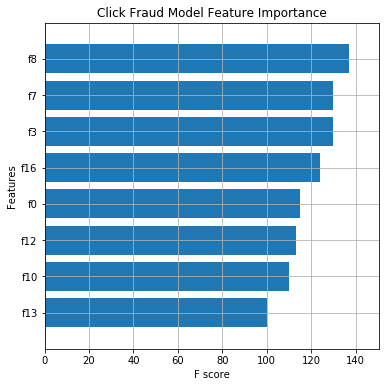

exp2


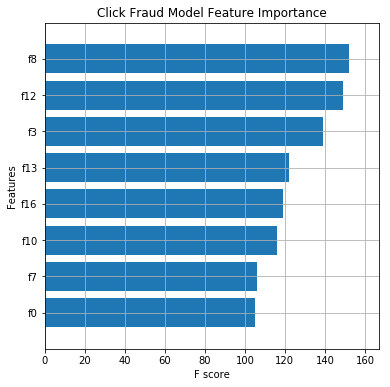

exp3


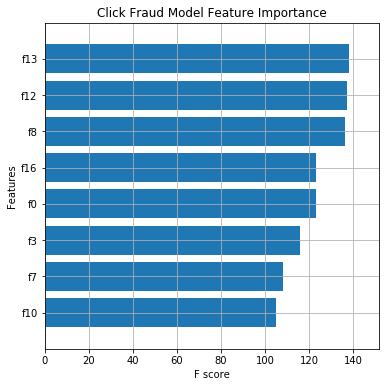

In [147]:
## Unpack model files
exp_lst = ['exp1', 'exp2', 'exp3']

for exp in exp_lst:
    model_file = os.path.join(sm_output_loc, exp, s3_output_fn)
    print(exp)
    plot_ftr_imp(model_file)

Feature importance switched slightly as more data became available

In the order of importance
- f8 - number of clicks by ip, day, hr (ip, time, and day)
- f13 - app frequency
- f12 - number of clicks by ip, device, hr (ip, time, and device)
- f3 - channel
- f16 - channel freq (frequency with which the channel occurs in the dataset)
- f0 - app (the app itself)
- f7 - second (time is also important)
- f10 - number of clicks by ip, hour and operating system (ip, time and os)

In [88]:
test_data.shape[0]

120000

- Deploy each of the trained models for inference
- Change data_loc to deploy pertinent model

In [124]:
# predict whether the click will result in app download
# deploy trained model in SageMaker

# Use SageMaker Python SDK

# Assign data location for each of the experiments and deploy all the 3 models

data_loc = 's3://ai-in-aws/Click-Fraud/output/exp1'

# data_loc = 's3://ai-in-aws/Click-Fraud/output/exp2'

# data_loc = 's3://ai-in-aws/Click-Fraud/output/exp3'

model_loc = os.path.join(data_loc, s3_output_fn)
xgb_model = Model(model_data=model_loc, image=container, role=role)


In [ ]:
xgb_model.deploy(initial_instance_count=1,
                           instance_type='ml.m4.xlarge')

### Inferences
Run inferences across all the three endpoints. Take a note of endpoints and update the endpoint_lst below

In [130]:
# Get the deployed endpoint names 

enpoint_lst = ['xgboost-2019-09-08-13-19-41-305' , 'xgboost-2019-09-08-12-37-01-451', 'xgboost-2019-09-08-12-53-08-390']  #exp1, exp2, exp3
predictions = {}

for ind, endpoint in enumerate(enpoint_lst):
    xgb_predictor = sagemaker.predictor.RealTimePredictor(endpoint, sagemaker_session=sess, serializer=csv_serializer, deserializer=None, content_type='text/csv', accept=None)
    predictions[exp_lst[ind]] = xgb_predictor.predict(test_data.values[:20000, 1:]).decode('utf-8')
    predictions[exp_lst[ind]] = np.fromstring(predictions[exp_lst[ind]][1:], sep=',') #A new 1-D array initialized from text data in a string.
#     pd.crosstab(index=test_data.as_matrix()[:10000, 0], columns=np.round(predictions[exp_lst[ind]]), rownames=['actual'], colnames=['predictions'])
#     plt.hist(predictions1)
#     plt.show()
    c_mat = confusion_matrix(test_data.values[:20000, 0], np.round(predictions[exp_lst[ind]])) ## Predicted vs. actual outcome
  #  accuracy = round(accuracy_score(test_data.values[:20000, 0], np.round(predictions[exp_lst[ind]])), 4) ## Overall accuracy
    auc = round(roc_auc_score(test_data.values[:20000, 0], np.round(predictions[exp_lst[ind]])), 4)
    print('For {} auc is {}, accuracy is {}, and confusion matrix is {}'.format(exp_lst[ind], auc, accuracy, c_mat))
    #print('For {} auc is {}, and confusion matrix is {}'.format(exp_lst[ind], auc, c_mat))

For exp1 auc is 0.802, accuracy is 0.9864, and confusion matrix is [[19822   142]
 [   14    22]]
For exp2 auc is 0.8556, accuracy is 0.9864, and confusion matrix is [[19745   219]
 [   10    26]]
For exp3 auc is 0.8684, accuracy is 0.9864, and confusion matrix is [[19700   264]
 [    9    27]]


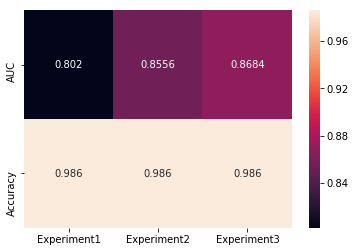

In [132]:
Index= ['AUC', 'Accuracy']
df_model_perf = pd.DataFrame({'Experiment1': [0.802, 0.986], 'Experiment2': [0.8556, 0.986], 'Experiment3': [0.8684, 0.986]}, index=Index)

sns.heatmap(df_model_perf, annot=True, fmt='.4g')


As can be seen above, it is important to establish feedback loop in machine learning life cycle to learn in real time dynamic patterns in data